<a href="https://colab.research.google.com/github/RamezNabil/Character-Recognition-CNN/blob/main/Identifying_Characters_CNN_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying characters from Google Street View images with CNN

##Setting up Kaggle api

In [ ]:
!pip install -q kaggle

In [ ]:
# Upload your Kaggle API json file
from google.colab import files
files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

##Downloading the dataset

In [ ]:
!kaggle competitions download -c street-view-getting-started-with-julia

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

##Viewing the dataset
* 20x20x3 input images (.Bmp)
* 6283 training inputs
* 6220 testing inputs
* 62 class labels (0-9, a-z, A-Z)


In [ ]:
# Unzipping the dataset into content/Dataset
!unzip "/content/trainResized.zip" -d Dataset
!unzip "/content/testResized.zip" -d Dataset

In [ ]:
len(os.listdir('/content/Dataset/trainResized')), len(os.listdir('/content/Dataset/testResized'))

(6283, 6220)

In [ ]:
# Viewing unique class labels and their count
data_labels = pd.read_csv('/content/trainLabels.csv')
print(sorted(data_labels['Class'].unique()))
print(len(data_labels['Class'].unique()))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
62


In [ ]:
def get_class(ID):
  '''
  Gets class label from image ID
  '''
  return data_labels['Class'][ID-1]

In [ ]:
# View an image

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)

  # Getting class label from its image id
  image_id = random_image[0].split('.')[0]
  plt.title(get_class(int(image_id)))
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (20, 20, 3)


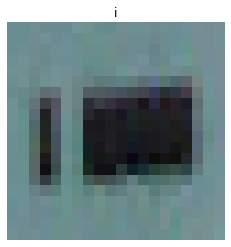

In [ ]:
view_random_image("Dataset/", "trainResized");

## Pre-processing Data

In [ ]:
# Getting X_train, y_train
X_train_path = '/content/Dataset/trainResized/'
X_train = []
y_train = []

for img in os.listdir(X_train_path):
  feature = mpimg.imread(X_train_path + img)
  X_train.append(feature)
  img_id = int(img.split('.')[0])
  y_train.append(get_class(img_id))

In [ ]:
# Getting X_test, ids
X_test_path = '/content/Dataset/testResized/'
X_test = []
ids = []

for img in os.listdir(X_test_path):
  feature = mpimg.imread(X_test_path + img)
  X_test.append(feature)
  img_id = int(img.split('.')[0])
  ids.append(img_id)

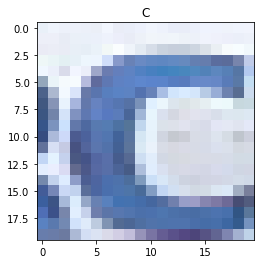

In [ ]:
# Visualizing X_train and y_train
random_index = random.sample(range(0,len(X_train)), 1)
random_index = random_index[0]
plt.imshow(X_train[random_index])
plt.title(y_train[random_index]);

In [ ]:
# Some X_train images are greyscale (20x20) instead of RGB (20x20x3)
# Removing (cutting) greyscale images from dataset
X_train_cut = []
y_train_cut = []
index = 0
for img in X_train:
  if img.shape == (20,20,3):
    X_train_cut.append(img)
    y_train_cut.append(y_train[index])
  index = index + 1

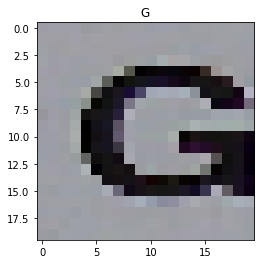

In [ ]:
#@title Visualizing X_train_cut and y_train_cut
random_index = random.sample(range(0,len(X_train_cut)), 1)
random_index = random_index[0]
plt.imshow(X_train_cut[random_index])
plt.title(y_train_cut[random_index]);

In [ ]:
# Some X_test images are greyscale (20x20) instead of RGB (20x20x3)
# repeating the greyscale values 3 times to make it 20x20x3
for index in range(len(X_test)):
  if X_test[index].shape == (20,20):
    X_test[index] = np.reshape (np.concatenate((X_test[index], X_test[index], X_test[index])), [20,20,3] )

X_test_modified = np.array(X_test)
X_test_modified.shape

(6220, 20, 20, 3)

In [ ]:
# Turning feature data into tensors
X_train_tensor = tf.constant(np.array(X_train_cut).reshape(-1,20,20,3))
X_test_tensor = tf.constant(X_test_modified.reshape(-1,20,20,3))
X_train_tensor.shape, X_test_tensor.shape

(TensorShape([6280, 20, 20, 3]), TensorShape([6220, 20, 20, 3]))

### Normalization

In [ ]:
# Normalizing Data
X_train_norm = X_train_tensor/255
X_test_norm = X_test_tensor/255
X_train[0], X_train_norm[0]

In [ ]:
# Indexing class labels 
unique_labels = sorted(data_labels['Class'].unique())
y_train_index = []
for label in y_train_cut:
  y_train_index.append(unique_labels.index(label))
y_train_index[:10]

[29, 0, 29, 10, 23, 38, 49, 28, 12, 49]

In [ ]:
# Turning trianing labels into a tensor
y_train_tensor = tf.constant(np.array(y_train_index), dtype=tf.uint8)
y_train_tensor

<tf.Tensor: shape=(6280,), dtype=uint8, numpy=array([29,  0, 29, ..., 11, 50, 11], dtype=uint8)>

### Spliting data (Not used)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_train_cut,y_train_cut,test_size =0.2, random_state=42, shuffle = True)

# Turning into numpy
X_train_sp = np.array(X_train_sp).reshape(-1,20,20,3)
X_test_sp = np.array(X_test_sp).reshape(-1,20,20,3)
y_train_sp = np.array(y_train_sp)
y_test_sp = np.array(y_test_sp)

# Normalization
X_train_sp = X_train_sp / 255.
X_test_sp = X_test_sp / 255.

# Indexing train labels 
unique_labels = sorted(data_labels['Class'].unique())
y_train_index = []
for label in y_train_sp:
  y_train_index.append(unique_labels.index(label))
y_train_sp = np.array(y_train_index)

# Indexing test labels 
unique_labels = sorted(data_labels['Class'].unique())
y_train_index = []
for label in y_test_sp:
  y_train_index.append(unique_labels.index(label))
y_test_sp = np.array(y_train_index)

NameError: ignored

## Building the Model
* Model 1: Tiny VGG: 76% accuracy at 50 epochs and lr = 0.001
* Model 2: VGG-19: 7.31% accuracy at 5 epochs and lr = 0.001
* Model 3: Tiny VGG with extra neurons: 99% at 50 epochs and lr = 0.001
* Model 4: Tiny VGG with extra neurons and regularization: 

In [ ]:
# Checking shapes
X_train_norm.shape, y_train_tensor.shape

(TensorShape([6280, 20, 20, 3]), TensorShape([6280]))

### Model 1 Tiny VGG

In [ ]:
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(20, 20, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(62, activation="softmax")
])

# Compile the model
model_1.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(X_train_norm, y_train_tensor, epochs=50)

# Plotting loss
pd.DataFrame(history_1.history['accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")

### Model 2 VGG-19

In [ ]:
from tensorflow.keras import layers, models, regularizers

model_2 = models.Sequential()

model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(20, 20, 3)))
model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model_2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'same'))

model_2.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'same'))

model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'same'))

model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), strides= (2,2), padding= 'same'))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(4096))
model_2.add(layers.Activation('relu'))

model_2.add(layers.Dense(4096))
model_2.add(layers.Activation('relu'))

model_2.add(layers.Dense(1000))
model_2.add(layers.Activation('relu'))

model_2.add(layers.Dense(62, activation='softmax'))

# Compile the model
model_2.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(X_train_norm, y_train_tensor, epochs=5, batch_size=32)

# Plotting loss
pd.DataFrame(history_2.history['accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")


###Model 3 Tiny VGG with extra neurons

In [ ]:
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=100, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(20, 20, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(100, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'

  tf.keras.layers.Conv2D(100, 3, activation="relu"),
  tf.keras.layers.Conv2D(100, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(62, activation="softmax")
])

# Compile the model
model_3.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(X_train_norm, y_train_tensor, epochs=50)

# Plotting loss
pd.DataFrame(history_3.history['accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")


###Model 4 Tiny VGG with extra neurons and regularization

In [ ]:
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=100, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(20, 20, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(100, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'

  tf.keras.layers.Conv2D(100, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Conv2D(100, 3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.MaxPool2D(2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(62, activation="softmax")
])

# Compile the model
model_4.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(X_train_norm, y_train_tensor, epochs=100)
# history_4 = model_4.fit(X_train_sp, y_train_sp, epochs=100, validation_data=(X_test_sp, y_test_sp))

# Plotting loss
pd.DataFrame(history_4.history['accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")

### Model Best so far

In [ ]:
tf.random.set_seed(42)

# Make the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=(20, 20, 3)),
  tf.keras.layers.Dropout(.1),

  tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
  tf.keras.layers.Dropout(.2),

  tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.BatchNormalization(),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.04)),
  tf.keras.layers.Dense(62, activation="softmax")
])

# Compile the model
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr = 0.001),
              metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, y_train, epochs=24, validation_data=(X_test, y_test))

# Plotting loss
pd.DataFrame(history.history['val_accuracy']).plot()
plt.xlabel("Epochs")
plt.ylabel("accuracy")

## Getting the output

In [ ]:
# Getting Predictions
y_pred = model_4.predict(X_test_norm)

In [ ]:
# Turning predictions into class labels
y_pred_ids = tf.argmax(y_pred,axis=1)
y_pred_labels = []
for pred in y_pred_ids:
   y_pred_labels.append(unique_labels[pred])
y_pred_labels

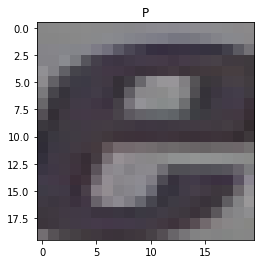

In [ ]:
#@title Visualizing X_test_norm and y_pred_labels
random_index = random.sample(range(0,len(X_test_norm)), 1)
random_index = random_index[0]
plt.imshow(X_test_norm[random_index])
plt.title(y_pred_labels[random_index]);

In [ ]:
# Making csv file for submission
df = pd.DataFrame({'ID':ids, 'Class':y_pred_labels})
df.to_csv(r'submission8.csv', index = False)